In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 生成数据
def create_dataset():
    np.random.seed(1)
    m = 400 # 数据量
    N = int(m / 2) # 每个标签的实例数
    D = 2 # 数据维度
    X = np.zeros((m, D)) # 数据矩阵
    Y = np.zeros((m, 1), dtype='uint8') # 标签维度
    a = 4
    
    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[ix] = j
    
    X = X.T
    Y = Y.T
    
    return X, Y

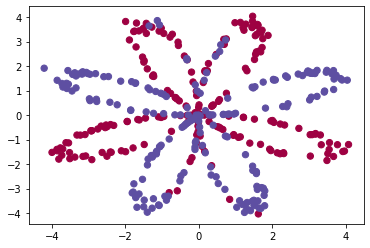

In [6]:
X, Y = create_dataset()
plt.scatter(X[0, :], X[1, :], c = Y[0], s = 40, cmap=plt.cm.Spectral)

In [7]:
# 定义网络结构
def layer_sizes(X, Y):
    n_x = X.shape[0] # 输入层大小
    n_h = 4 # 隐层大小
    n_y = Y.shape[0] # 输出层大小
    return (n_x, n_h, n_y)

In [19]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

[![pPpZhDO.md.png](https://s1.ax1x.com/2023/07/30/pPpZhDO.md.png)](https://imgse.com/i/pPpZhDO)

## 初始化模型参数

假设：
- W1为输入层到隐层的权重数组
- b1为输入层到隐层的前偏数组
- W2为隐层到输出层的权重数组
- b2为隐层到输出层的偏置数组

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    return parameters

## 前向传播

在定义好网络结构并初始化参数完成之后，就要开始执行神经网络的训练过程了。而训练的第一步则是执行前向传播计算。假设隐层的激活函数为tanh函数， 输出层的激活函数为sigmoid函数。则前向传播计算表示为：

[![pPpZvqS.png](https://s1.ax1x.com/2023/07/30/pPpZvqS.png)](https://imgse.com/i/pPpZvqS)

In [11]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    # 前向计算
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    assert (A2.shape == (1, X.shape[1]))
    
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2':Z2,
        'A2':A2
    }
    return A2, cache

## 计算损失

前向传播计算完成后我们需要确定以当前参数执行计算后的的输出与标签值之间的损失大小。

交叉熵损失：
[![pPpeQR1.png](https://s1.ax1x.com/2023/07/30/pPpeQR1.png)](https://imgse.com/i/pPpeQR1)


In [13]:
def compute_cost(A2, Y, paramters):
    # 训练样本量
    m = Y.shape[1]
    # 计算交叉熵损失
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    cost = - 1 / m * np.sum(logprobs)
    # 维度压缩
    cost = np.squeeze(cost)
    
    assert (isinstance(cost, float))
    return cost

## 反向传播
当前向传播和当前损失确定之后，就需要继续执行反向传播过程来调整权值了。中间涉及到各个参数的梯度计算
[![pPpelxx.png](https://s1.ax1x.com/2023/07/30/pPpelxx.png)](https://imgse.com/i/pPpelxx)

In [21]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    # 获取W1， W2
    W1 = parameters['W1']
    W2 = parameters['W2']
    # 获取A1 ， A2
    A1 = cache['A1']
    A2 = cache['A2']
    # backward
    dZ2 = A2 - Y
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2)*(1-np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    return grads

## 权重更新
[![pPpecdg.png](https://s1.ax1x.com/2023/07/30/pPpecdg.png)](https://imgse.com/i/pPpecdg)

In [25]:
def update_parameters(parameters, grads, learn_rate = 1.2):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 -= dW1 * learn_rate
    b1 -= b1 * learn_rate
    W2 -= dW2 * learn_rate
    b2 -= b2 * learn_rate
    
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2':b2
    }
    return parameters


## 神经网络模型

In [26]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # 初始化
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #  梯度下降和参数循环更新
    for i in range(0, num_iterations):
        # forward
        A2, cache = forward_propagation(X, parameters)
        # cost
        cost = compute_cost(A2, Y, parameters)
        # backward
        grads = backward_propagation(parameters, cache, X, Y)
        # update
        parameters = update_parameters(parameters, grads, learn_rate=1.2)
        # 打印损失
        if print_cost and i % 1000 == 0:
            print('cost after iteration %i: %f'%(i, cost))
            
    return parameters

In [31]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

---

## 测试

In [28]:
parameters = nn_model(X, Y, n_h=4, num_iterations=10000,print_cost=True)

cost after iteration 0: 0.693162
cost after iteration 1000: 0.261626
cost after iteration 2000: 0.241866
cost after iteration 3000: 0.232809
cost after iteration 4000: 0.227215
cost after iteration 5000: 0.223375
cost after iteration 6000: 0.220594
cost after iteration 7000: 0.218507
cost after iteration 8000: 0.216897
cost after iteration 9000: 0.215628


In [32]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + 
      np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')


Accuracy: 91%


In [33]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.25 %
Accuracy for 4 hidden units: 91.0 %
Accuracy for 5 hidden units: 91.5 %
Accuracy for 10 hidden units: 92.25 %
Accuracy for 20 hidden units: 92.25 %


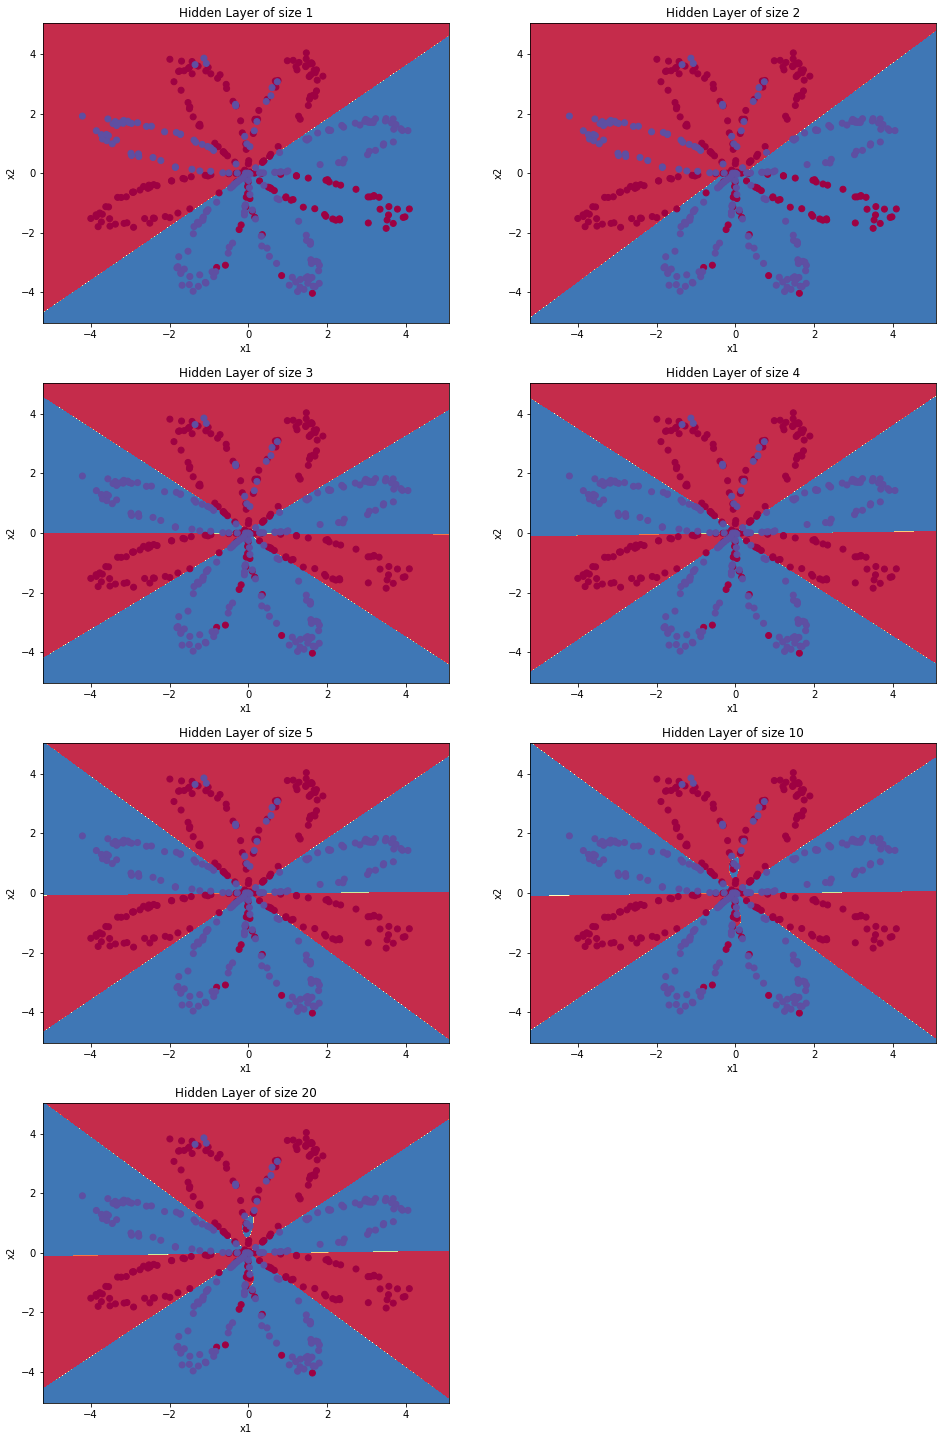

In [34]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))